In [ ]:
# Imports
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import pickle
import collections
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve
)

In [2]:
# Use Mixed Precision (save VRAM)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("mixed precision enabled.")

mixed precision enabled.


In [3]:
# Load Preprocessed Data --- balanced checked
DATA_PATH = "/kaggle/input/preprocessed-mammo-splits"  
train = np.load(os.path.join(DATA_PATH, "train_data.npz"))
val = np.load(os.path.join(DATA_PATH, "val_data.npz"))
test = np.load(os.path.join(DATA_PATH, "test_data.npz"))

X_train, y_train = train["X"], train["y"]
X_val, y_val = val["X"], val["y"]
X_test, y_test = test["X"], test["y"]


In [4]:
# Normalize
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [5]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.1308917197452228, 1: 0.8962645128722867}


In [6]:
def convert_to_rgb(image, label):
    image_rgb = tf.image.grayscale_to_rgb(image)  
    image_rgb = tf.squeeze(image_rgb) 
    return image_rgb, label

In [7]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Expand dims because TF expects (H, W, 1) from (H, W)
X_train = X_train[..., np.newaxis].astype("float32")
X_val = X_val[..., np.newaxis].astype("float32")
X_test = X_test[..., np.newaxis].astype("float32")

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle, batch, convert to RGB, prefetch
train_ds = (
    train_ds.shuffle(1024)
    .map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds.map(convert_to_rgb, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


I0000 00:00:1745316116.856179      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745316116.856865      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Validation class distribution: Counter({1: 1748, 0: 1386})

Evaluating VGG16 (.keras)...
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step


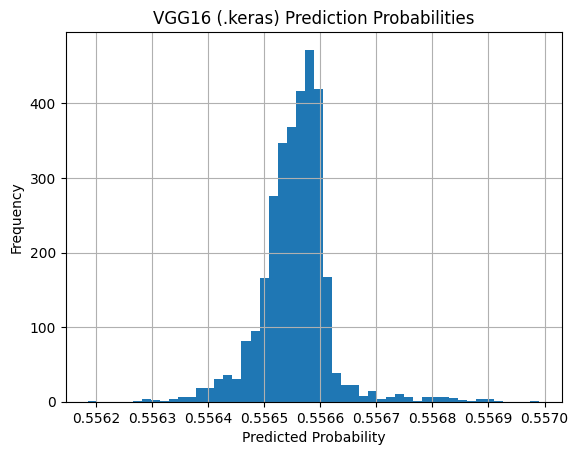


Best threshold (Youden's J): 0.5566

Metrics for VGG16 (.keras):
Confusion Matrix:
[[983 403]
 [965 783]]
Precision: 0.6602
Recall: 0.4479
F1 Score: 0.5337
ROC-AUC Score: 0.6012

Evaluating VGG16 (.h5)...
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step


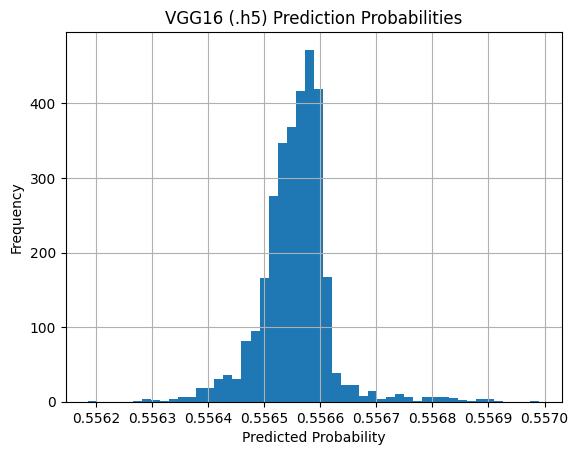


Best threshold (Youden's J): 0.5566

Metrics for VGG16 (.h5):
Confusion Matrix:
[[983 403]
 [965 783]]
Precision: 0.6602
Recall: 0.4479
F1 Score: 0.5337
ROC-AUC Score: 0.6012

Plotting Training History...


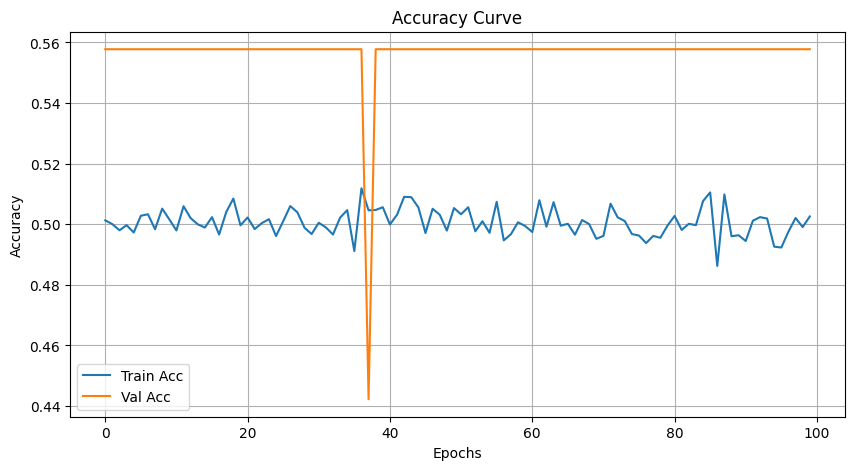

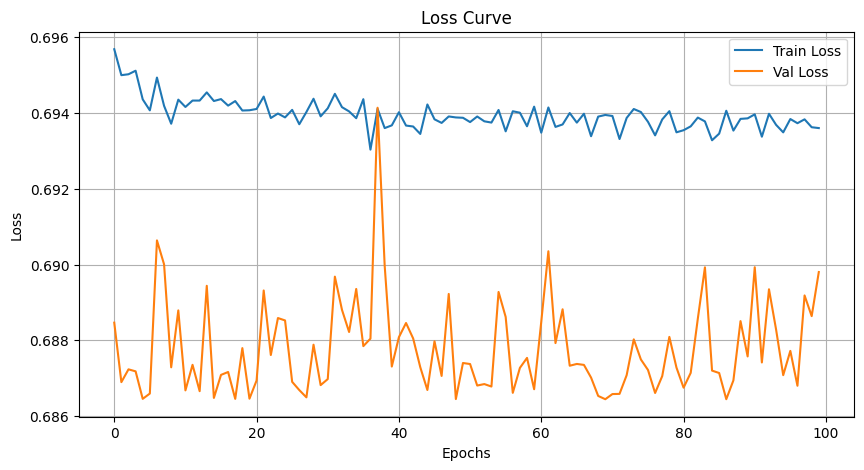


All evaluations and visualizations complete.


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import pickle
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve
)
from keras.utils import custom_object_scope

# Define a proper custom layer that can handle the dtype parameter
class Cast(tf.keras.layers.Layer):
    def __init__(self, dtype=None, **kwargs):
        super(Cast, self).__init__(**kwargs)
        # Handle dtype as string or TensorFlow dtype
        if dtype is None:
            self._dtype_value = tf.float32
        elif isinstance(dtype, str):
            self._dtype_value = tf.dtypes.as_dtype(dtype)
        else:
            self._dtype_value = dtype
    
    @property
    def dtype(self):
        return self._dtype_value
    
    def call(self, inputs):
        return tf.cast(inputs, self._dtype_value)
    
    def get_config(self):
        config = super(Cast, self).get_config()
        # Store dtype as string for serialization
        if hasattr(self._dtype_value, 'name'):
            dtype_str = self._dtype_value.name
        else:
            dtype_str = str(self._dtype_value)
        config.update({"dtype": dtype_str})
        return config

# Collect true labels from val_ds
y_true = np.concatenate([label.numpy() for _, label in val_ds])
print("Validation class distribution:", collections.Counter(y_true))

# Correct file paths (based on your Kaggle directory)
VGG_KERAS_PATH = "/kaggle/input/vgg-on-mendeley-dataset/tensorflow2/default/1/TL models-INbrest+MIAS+DDSM/VGG16.keras"
VGG_H5_PATH = "/kaggle/input/vgg-on-mendeley-dataset/tensorflow2/default/1/TL models-INbrest+MIAS+DDSM/VGG16_trained_model.h5"
VGG_HISTORY_PATH = "/kaggle/input/vgg-on-mendeley-dataset/tensorflow2/default/1/TL models-INbrest+MIAS+DDSM/VGG16_history.pkl"

# Metric function
def log_metrics(y_true, y_probs, model_name):
    plt.hist(y_probs, bins=50)
    plt.title(f"{model_name} Prediction Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print(f"\nBest threshold (Youden's J): {best_thresh:.4f}")
    
    y_pred = (y_probs > best_thresh).astype("int32")
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    
    print(f"\nMetrics for {model_name}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

# Try to load and evaluate .keras model
try:
    print("\nEvaluating VGG16 (.keras)...")
    # Try with custom objects first for .keras model too
    with custom_object_scope({'Cast': Cast}):
        model_keras = tf.keras.models.load_model(VGG_KERAS_PATH)
    
    y_probs_keras = model_keras.predict(val_ds, verbose=1).squeeze()
    log_metrics(y_true, y_probs_keras, "VGG16 (.keras)")
except Exception as e:
    print(f"Error loading .keras model: {e}")
    print("Continuing with .h5 model...")

# Load and evaluate .h5 model with proper custom layer
print("\nEvaluating VGG16 (.h5)...")
custom_objects = {'Cast': Cast}

with custom_object_scope(custom_objects):
    model_h5 = tf.keras.models.load_model(VGG_H5_PATH)

# Evaluate the model after loading
y_probs_h5 = model_h5.predict(val_ds, verbose=1).squeeze()
log_metrics(y_true, y_probs_h5, "VGG16 (.h5)")

# Plot training history
try:
    print("\nPlotting Training History...")
    with open(VGG_HISTORY_PATH, 'rb') as f:
        history = pickle.load(f)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history['accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error plotting history: {e}")

print("\nAll evaluations and visualizations complete.")

In [19]:
print(val_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
